<a href="https://colab.research.google.com/github/ovsienkobohdan/arrhythmia-detection/blob/main/model_prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
!pip install wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import wfdb
from tqdm import tqdm
import cv2
from multiprocessing import Process
import warnings
warnings.filterwarnings('ignore')

--2021-08-09 22:28:27--  https://physionet.org/files/mitdb/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/mitdb/1.0.0/index.html’

physionet.org/files     [ <=>                ]  22.88K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-08-09 22:28:27 (649 MB/s) - ‘physionet.org/files/mitdb/1.0.0/index.html’ saved [23426]

Loading robots.txt; please ignore errors.
--2021-08-09 22:28:27--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

--2021-08-09 22:28:27--  https://physionet.org/files/mitdb/1.0.0/mitdbdir/
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
F

# Data

get statistic how much of each class do we have

In [ ]:
data_path = '/content/physionet.org/files/mitdb/1.0.0/'

In [ ]:
patients_file = "RECORDS"
with open(data_path+patients_file) as f:
    patients = f.read().splitlines()
print(patients)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [ ]:
def load_ecg(file, channels):
    record = wfdb.rdrecord(file, channels=channels)
    annotation = wfdb.rdann(file, 'atr')
    
    p_signal = record.p_signal
    
    assert record.fs == 360, 'sample freq is not 360'
    
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

In [ ]:
def beat_annotations(annotations, annotations_sample, beat):
  inds = np.in1d(annotations, beat)
  beats = annotations_sample[inds]
  return beats

In [ ]:
def segmentation(data_path, patients, channels=[0]):
  patient_beats = {}
  
  for patient in tqdm(patients):
    beats = {"N":[], "L":[], "R":[], "A":[], "V":[], "/":[], "E":[]}
    file_path = data_path + patient
    signal, atr_sym, atr_sample = load_ecg(file_path, channels=channels)

    for b in beats:
      type_beats = beat_annotations(annotations=atr_sym, annotations_sample=atr_sample, beat=b)
      
      for type_beat in type_beats:
        all_beats_ind = list(atr_sample).index(type_beat)

        if all_beats_ind!=0 and all_beats_ind!=(len(atr_sample)-1):
          prev_beat = atr_sample[all_beats_ind-1]
          next_beat = atr_sample[all_beats_ind+1]
          left_offset = abs(prev_beat - type_beat)//2
          right_offset = abs(next_beat - type_beat)//2
          beats[b].append(signal[type_beat - left_offset:type_beat+right_offset,0])

    beats = {key: value for key, value in beats.items() if len(value)>0}
    patient_beats[patient] = beats
  return patient_beats

In [ ]:
patients_types_beats = segmentation(data_path, patients)

100%|██████████| 48/48 [00:31<00:00,  1.53it/s]


TODO: Plot examples (signal and slices on that signal)

# Converting to images

In [ ]:
!mkdir data

In [ ]:
# def convert_to_img(beats_slices, directory, patient=None, beat_type=None):
#   for count, i in enumerate(beats_slices):
#     fig = plt.figure(frameon=False)
#     plt.plot(i)
#     plt.xticks([])
#     plt.yticks([])
#     for spine in plt.gca().spines.values():
#       spine.set_visible(False)
    
#     beat_type = "P" if beat_type == "/" else beat_type
#     file_name = directory + "/" + patient + "_" + str(count) + "_" + beat_type + ".png"
#     fig.savefig(file_name)
#     img_gray = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
#     img_gray = cv2.resize(img_gray, (128,128), interpolation = cv2.INTER_LANCZOS4)
#     cv2.imwrite(file_name, img_gray)
#     plt.close();

In [ ]:
def convert_to_img_(beats_slices, directory, patient, beats_types):
  for beat_type in beats_types:
    for count, i in enumerate(beats_slices[beat_type]):
      fig = plt.figure(frameon=False)
      plt.plot(i)
      plt.xticks([])
      plt.yticks([])
      for spine in plt.gca().spines.values():
        spine.set_visible(False)
      
      beat_type = "P" if beat_type == "/" else beat_type
      file_name = directory + "/" + patient + "_" + str(count) + "_" + beat_type + ".png"
      fig.savefig(file_name)
      img_gray = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
      img_gray = cv2.resize(img_gray, (128,128), interpolation = cv2.INTER_LANCZOS4)
      cv2.imwrite(file_name, img_gray)
      plt.close(fig);


TODO: plot examples of converting for every type

In [ ]:
# from tqdm import notebook 
# data_folder = "data"
# for patient in notebook.tqdm(patients_types_beats.keys(), desc="Patients", ):  
#   for beat_type in notebook.tqdm(patients_types_beats[patient].keys(),desc="Beats types"):
#     convert_to_img(patients_types_beats[patient][beat_type][:2], data_folder, patient, beat_type) 

Telling people that fucking matplitlib not working properly with threads so u need to use processes indtead

In [ ]:


data_folder = "data"
for patient in tqdm(patients_types_beats.keys(), desc="Patients"):  
  p = Process(target=convert_to_img_, args=(patients_types_beats[patient], data_folder, patient, patients_types_beats[patient].keys(), ))
  p.start()

In [ ]:
# import time
# from threading import Thread

In [ ]:
# %%time
# def sleepMe(i):
#     print("Поток %i засыпает на 5 секунд.\n" % i)
#     time.sleep(5)
#     print("Поток %i сейчас проснулся.\n" % i)

# for i in range(10):
#     th = Thread(target=sleepMe, args=(i, ))
#     th.start()

In [ ]:
# %%time
# def sleepMe(i):
#     print("Поток %i засыпает на 5 секунд.\n" % i)
#     time.sleep(5)
#     print("Поток %i сейчас проснулся.\n" % i)

# for i in range(10):
#     sleepMe(i)

# Data augmentation

In [ ]:
import glob
files = glob.glob('/content/data/*.png')
print(len(files))

18662


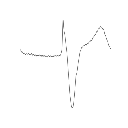

In [ ]:
from google.colab.patches import cv2_imshow
im = cv2.imread(files[100])
cv2_imshow(im)

In [ ]:
def beat_cropping(beat_img, file_url):
  cropping = {"leftTop": [[0,96],[0,96]], "centerTop": [[0,96],[16,112]],
              "rightTop": [[0,96],[32,128]], "leftCenter": [[16,122],[0,96]],
              "centerCenter": [[16,112],[16,112]], "rightCenter": [[16,112],[32,128]],
              "leftBottom": [[32,128],[0,96]], "centerBottom": [[32,128],[16,122]],
              "rightBottom": [[32,128],[32,128]]}
  for cropping_type in cropping.keys():
    inds = cropping[cropping_type]
    crop = beat_img[inds[0][0]:inds[0][1], inds[1][0]:inds[1][1]]
    beat_img = cv2.resize(beat_img, (128,128))
    print("file_url[:-5]",type(file_url[:-5]),file_url[:-5])
    print("cropping_type",type(cropping_type))
    print("file_url[-5]",type(file_url[-5]))
    new_file_url = str(file_url[:-5]) + cropping_type + "_" + file_url[-5] + '.png'
    cv2.imwrite(new_file_url, beat_img)

In [ ]:
files_to_crop = [file_path for file_path in files if file_path[-5] != "N"]

In [ ]:
len(files_to_crop)

5778

In [ ]:
files_to_crop[0]

'/content/data/217_689_P.png'

TODO: Multiprocess data augmentation

In [ ]:
for file_to_crop in tqdm(files_to_crop, desc="Files"):  
  beat_img = cv2.imread(file_to_crop)
  p = Process(target=beat_cropping, args=(beat_img, files_to_crop, ))
  p.start()